# RNN for Rat Data

In [1]:
# Imports + defaults settings.
%load_ext autoreload
%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings
import sys
import scipy
import pandas as pd

import rat_data
import disrnn
import rnn_utils
import subject_data

## Load Data

In [2]:
757 * 133

100681

In [3]:
rat_array = np.load('..\data\miller2018_rat16.npy')

dataset_train, dataset_test = rat_data.format_into_datasets(
    *rat_data.load_data_for_one_rat(rat_array)[:2], rnn_utils.DatasetRNN)
n_trials_per_session, n_sessions, _ = dataset_train._xs.shape

In [11]:
np.unique(dataset_train._ys, return_counts=True)

(array([-1.,  0.,  1.]), array([25052,  9292, 15618], dtype=int64))

In [8]:
# compare data and target
for i in range(20):
    print(dataset_train._xs[i,0,0],  dataset_train._ys[i,0,0])

0.0 1.0
1.0 1.0
1.0 -1.0
1.0 1.0
1.0 0.0
0.0 0.0
0.0 1.0
1.0 0.0
0.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 -1.0
1.0 1.0
1.0 0.0
0.0 1.0
1.0 1.0
1.0 0.0


In [12]:
# Number of latent units in the model.
latent_size = 5  #@param

# Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

# Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          obs_size = 2,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          obs_size = 2,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=1e-2)

, you may want to set n_steps to a very low value and return to the exercise when you 
have access to hardware acceleration.
Step 2000 of 2000; Loss: 5.6745e+03. (Time: 456.4s)

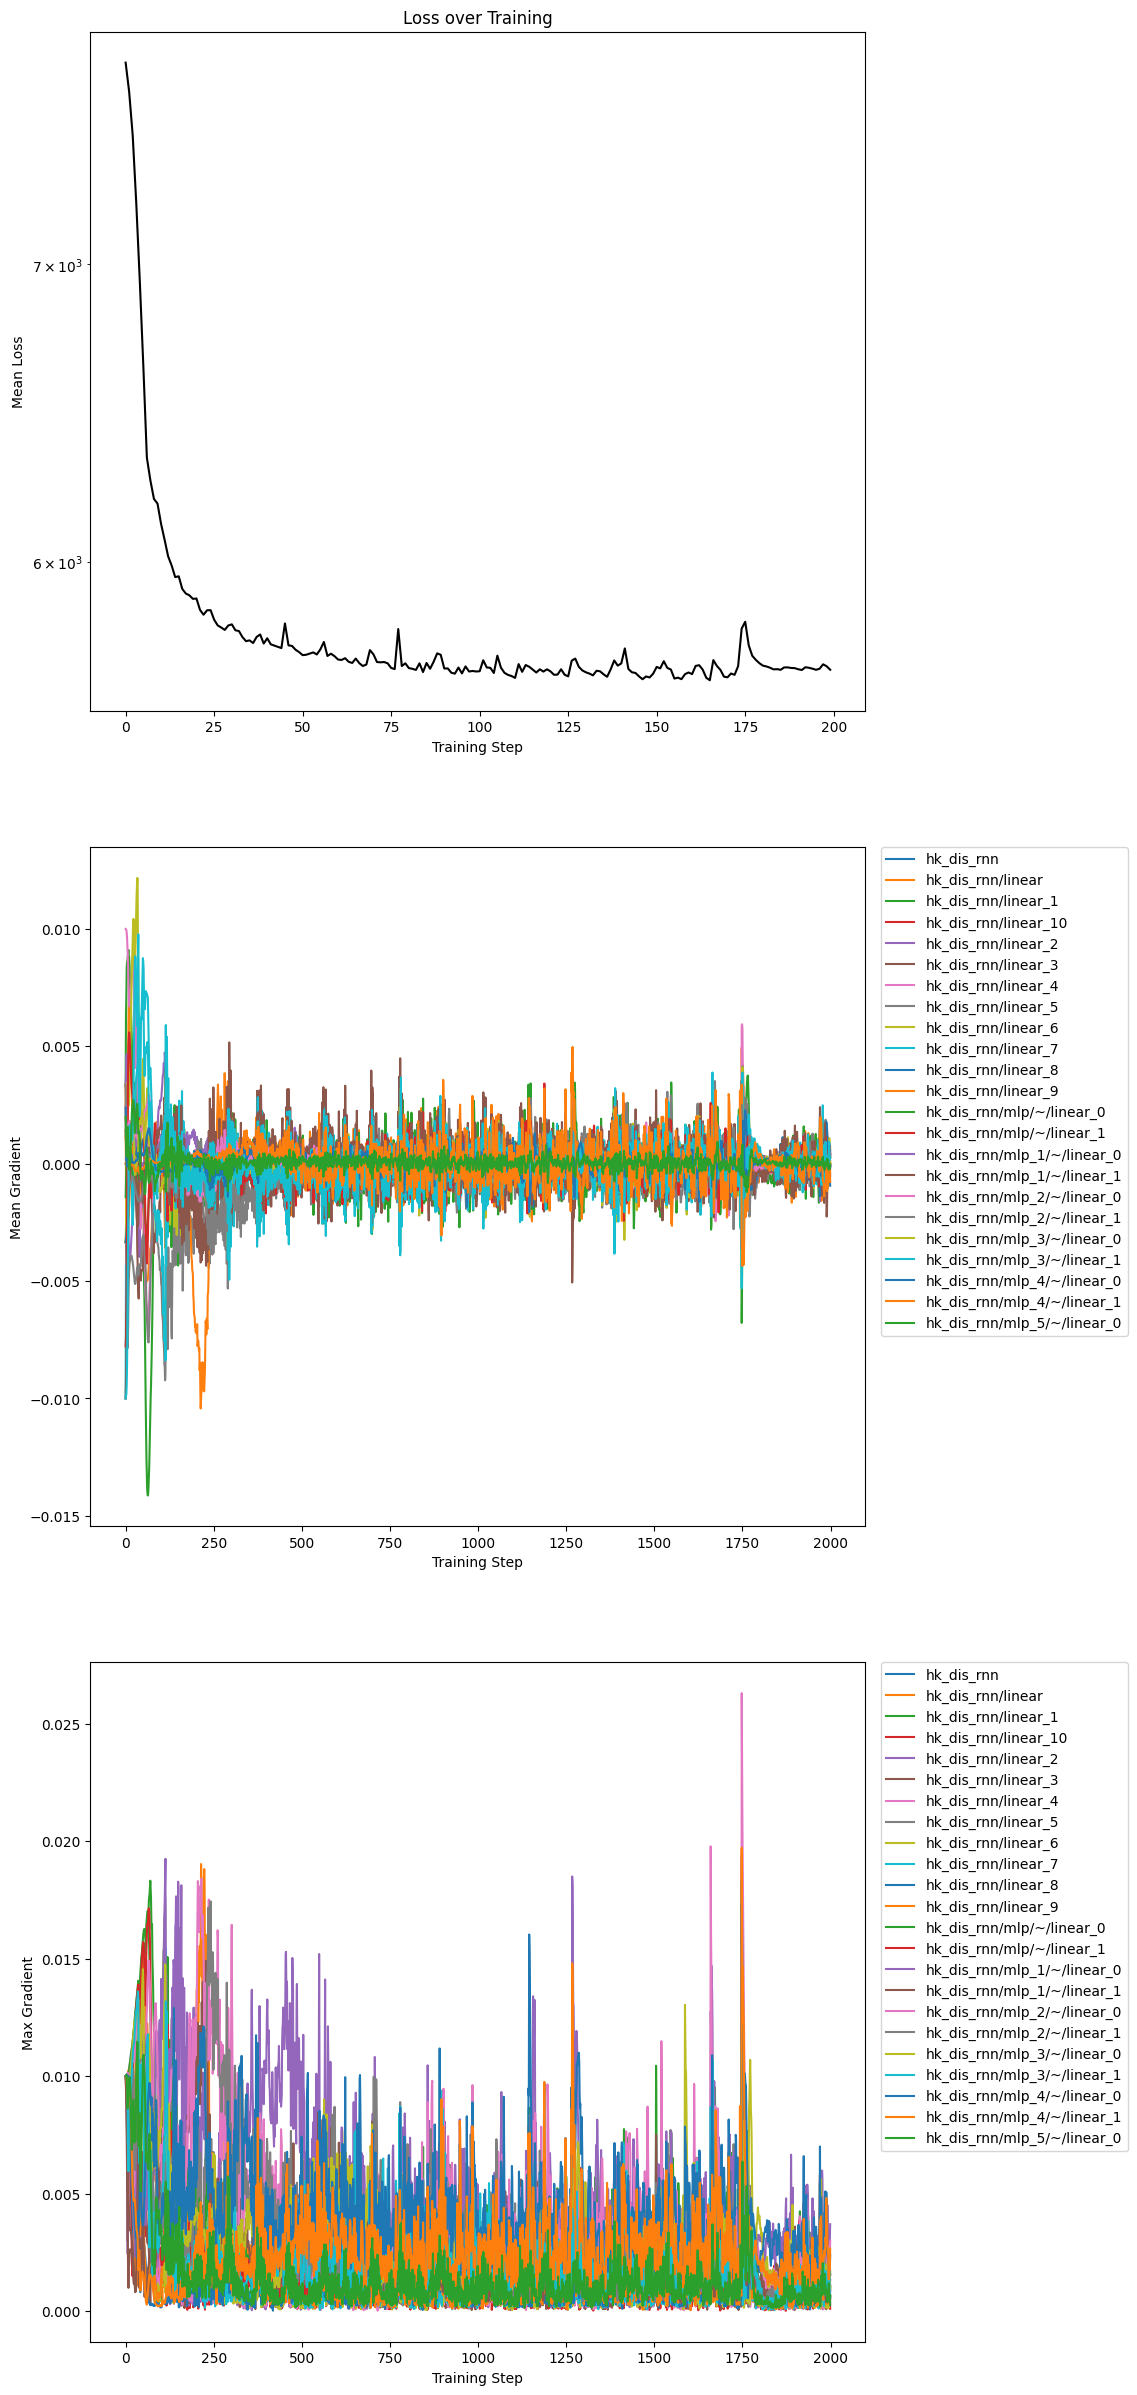

In [13]:
# You can experiment with different values, but colab has been tested with 1000.
print(('Warning: this step can be rather time consuming without GPU access. If you are not running on a GPU\n, '
       'you may want to set n_steps to a very low value and return to the exercise when you \n'
       'have access to hardware acceleration.'))
n_steps = 2000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train, 
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=True,
    truncate_seq_length=200,
)

In [21]:
# # Now fit more steps with a penalty, to encourage it to find a simple solution
# # You can experiment with different values, but colab has been tested with 3000.
# n_steps = 3000  #@param
# information_penalty = 1e-2 #@param

# disrnn_params, opt_state, losses = rnn_utils.train_model(
#     model_fun = make_disrnn,
#     dataset = dataset_train,
#     optimizer = optimizer,
#     loss_fun = 'penalized_categorical',
#     params=disrnn_params,
#     opt_state=opt_state,
#     penalty_scale=information_penalty,
#     n_steps=n_steps,
#     truncate_seq_length=200,
# )

In [14]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = subject_data.compute_log_likelihood(
    dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = subject_data.compute_log_likelihood(
    dataset_test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 60.8%
Held-Out Dataset
Normalized Likelihood: 59.3%


## Plot the choices made by the model and the actual choices.

In [15]:
xs, actual_choices = next(dataset_train) # performance for the training or test set
n_trials_per_session, n_subjects = actual_choices.shape[:2]
model_outputs, model_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)

model_outputs = jax.nn.softmax(model_outputs[:, :, :-1], axis=-1)  # Last entry is nans.

Plot the model predictions

In [17]:
actual_choices.shape

(757, 66, 1)

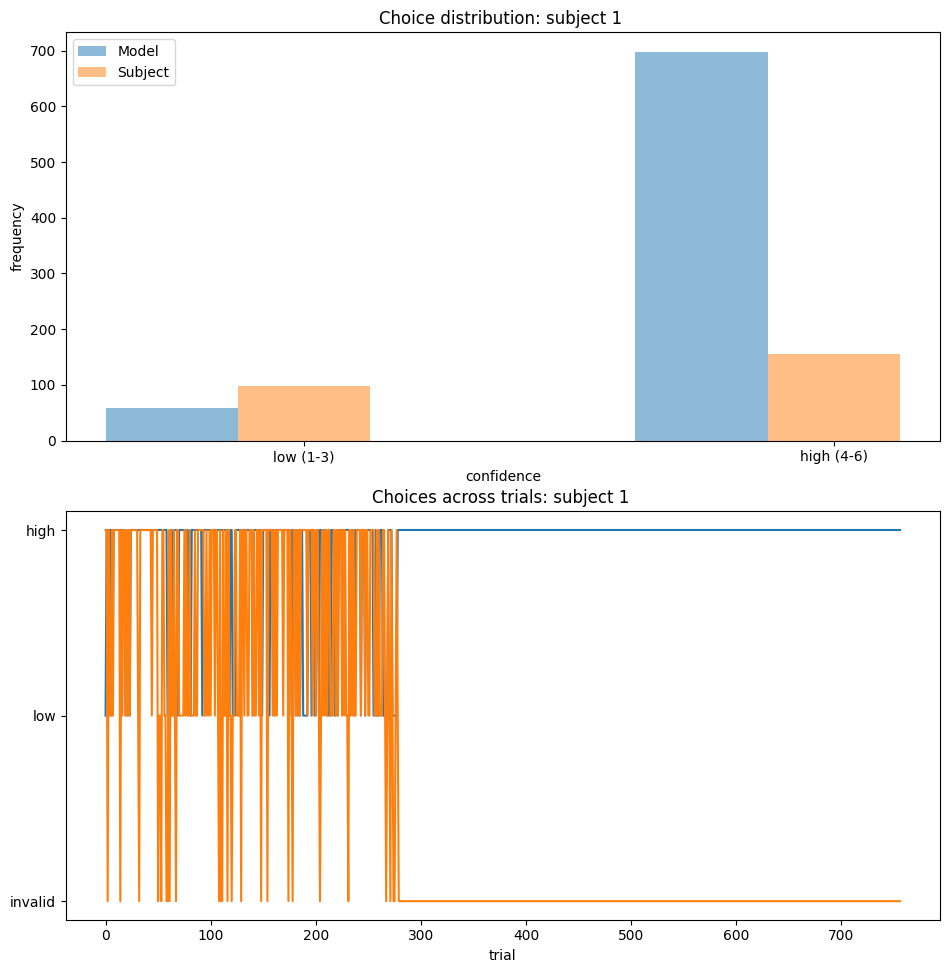

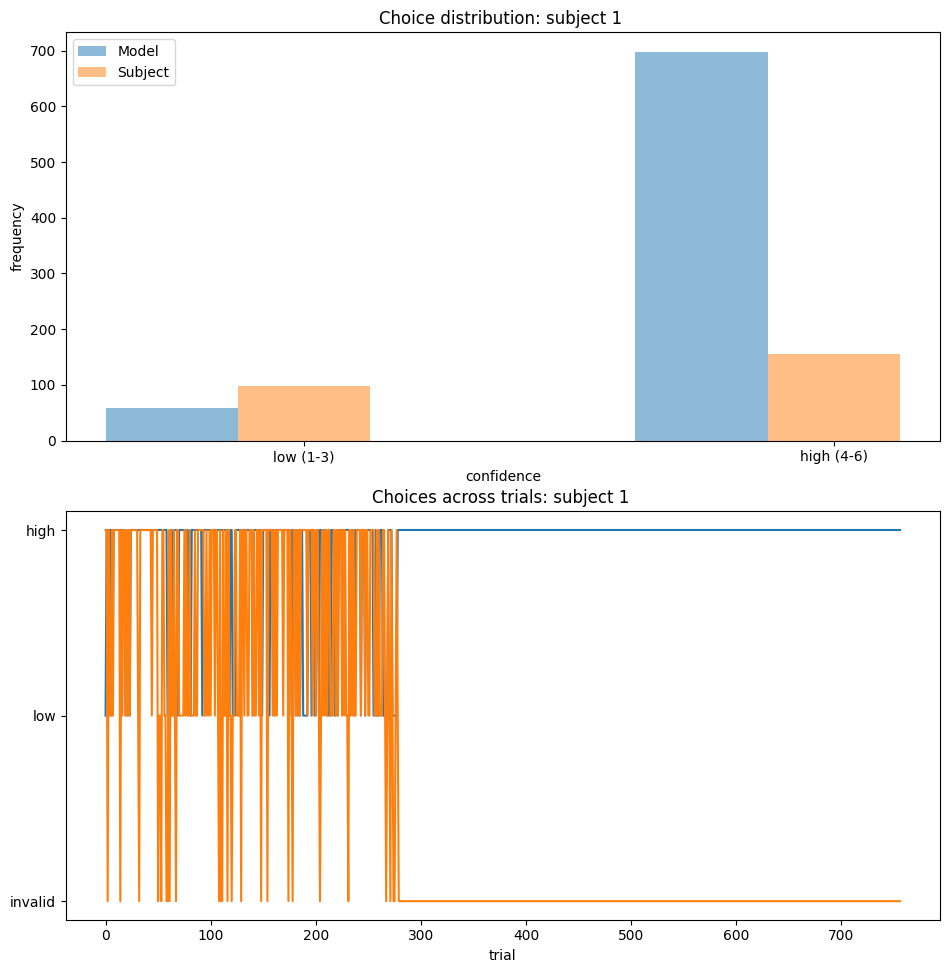

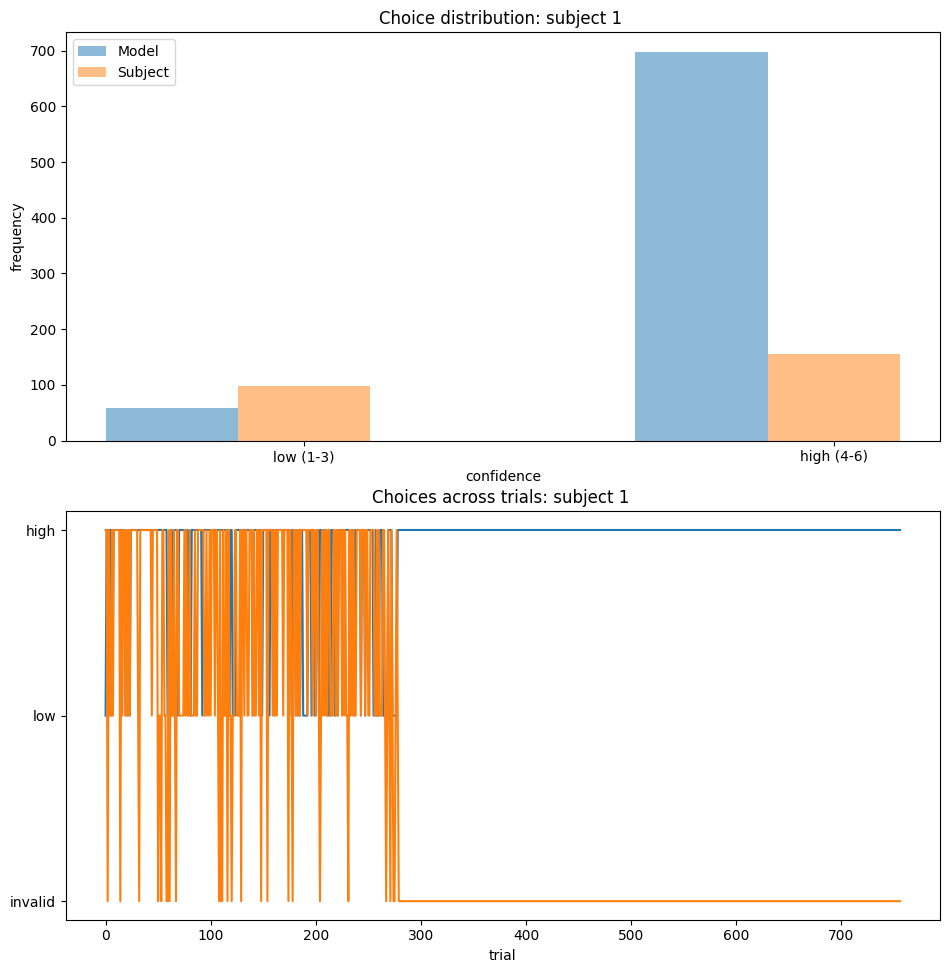

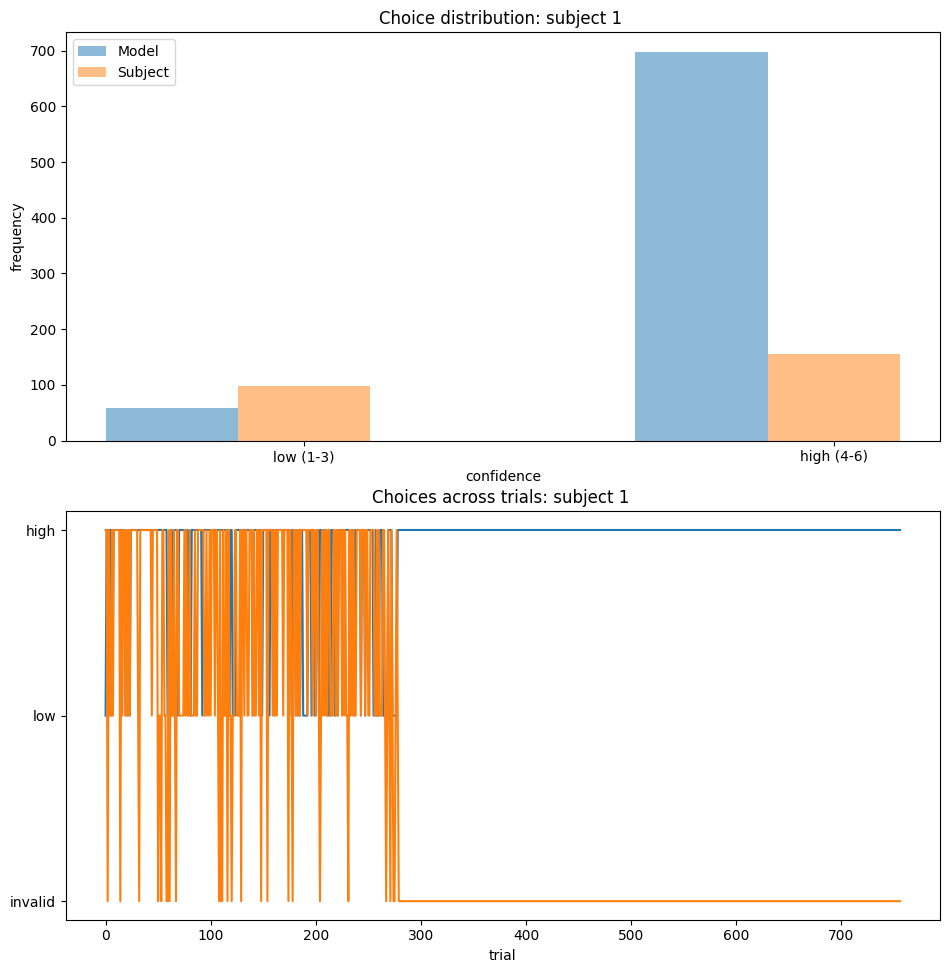

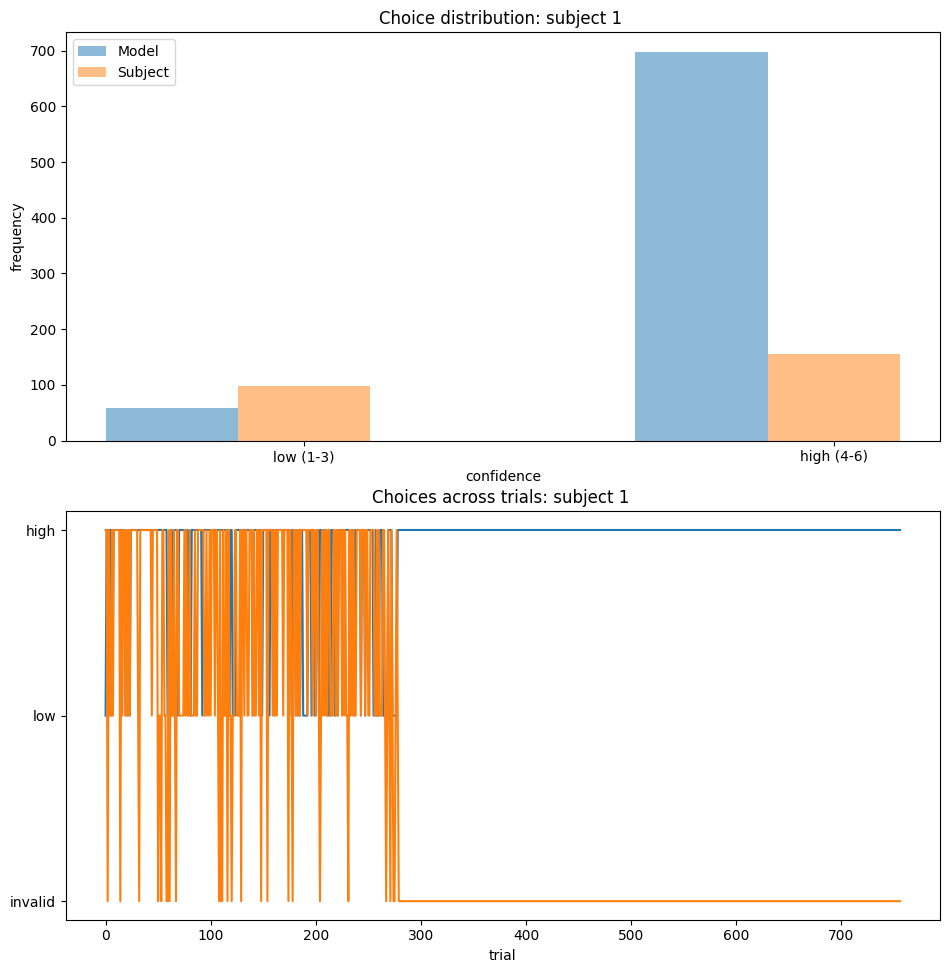

: 

In [ ]:
for i in range(model_outputs.shape[1]):
    for j in range(model_outputs.shape[0]):
        if actual_choices[j, i, 0] == -1:
            continue
        model_choice = np.argmax(model_outputs[:, i, :], axis=-1)
        model_counts = (np.sum(model_choice == 0), np.sum(model_choice == 1))

        subject_choice = actual_choices[:, i]
        subject_counts = (np.sum(subject_choice == 0), np.sum(subject_choice == 1))
        
        # Plot the distribution of choices for each subject
        labels = ("low (1-3)", "high (4-6)")
        all_choices = {'Model': model_counts, 'Subject': subject_counts}
        x = np.arange(len(labels))  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0

        #fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        fig, ax = plt.subplots(2, 1, figsize = (10, 10))
        fig.tight_layout(pad=3.0)

        for identity, count in all_choices.items():
            offset = width * multiplier
            rects = ax[0].bar(x + offset, count, width, alpha=0.5, label=identity)
            multiplier += 1

        ax[0].set_ylabel('frequency')
        ax[0].set_xlabel('confidence')
        ax[0].set_title('Choice distribution: subject {subject} '.format(subject=i+1))
        ax[0].set_xticks(x + width, labels)
        ax[0].legend(loc='upper left')
        
        # Plot the choices across all trials
        ax[1].plot(model_choice, label='Model')
        ax[1].plot(subject_choice, label='Subject')
        
        ax[1].set_xlabel('trial')
        ax[1].set_yticks([-1,0,1], labels=['invalid', 'low', 'high'])
        ax[1].set_title('Choices across trials: subject {subject} '.format(subject=i+1))

        plt.show()